In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import sklearn
import sklearn.model_selection
%matplotlib inline

## 1. Загружаем и обрабатываем данные (аналгично с первым случаем, поэтому уже без объяснений)

In [25]:
url = "https://raw.githubusercontent.com/Vodeneev/ML/main/2018_Financial_Data.csv"

data_raw = pd.read_csv(url)


In [26]:

cols_to_drop = ['priceCashFlowRatio', 'priceEarningsToGrowthRatio', 'enterpriseValueMultiple', 'effectiveTaxRate',

                'returnOnAssets', 'returnOnCapitalEmployed', 'nIperEBT', 'eBTperEBIT', 'operatingCycle',

                'cashConversionCycle', 'freeCashFlowOperatingCashFlowRatio', 'shortTermCoverageRatios', 'dividendPayoutRatio', 

               'Current ratio', 'ROIC', 'Return on Tangible Assets', 'Working Capital', '10Y Revenue Growth (per Share)', 

               '10Y Operating CF Growth (per Share)', '10Y Net Income Growth (per Share)',

                '10Y Shareholders Equity Growth (per Share)', '10Y Dividend per Share Growth (per Share)', 

               'niperEBT', 'ebtperEBIT']

data_raw_less_hos_beds_raion = data_raw.drop(cols_to_drop, axis=1)

In [27]:
for col in data_raw_less_hos_beds_raion.columns:

    pct_missing = np.mean(data_raw_less_hos_beds_raion[col].isnull())

clear_data = data_raw_less_hos_beds_raion

df_numeric = clear_data.select_dtypes(include=[np.number])

numeric_cols = df_numeric.columns.values

for col in numeric_cols:

    missing = clear_data[col].isnull()

    num_missing = np.sum(missing)

    

    if num_missing > 0:
        med = clear_data[col].median()

        clear_data[col] =clear_data[col].fillna(med)



for col in clear_data.columns:

    pct_missing = np.mean(clear_data[col].isnull())

   
data = clear_data


In [28]:
corr_mat = data.corr()

drop_col = corr_mat.where(np.triu(corr_mat > 0.98, k=1)).stack()

cols_to_drop = drop_col.index.droplevel(0).unique()

new_data = data.drop(cols_to_drop, axis=1)

data = new_data

corr_mat = data.corr()

new_data = data.drop('Unnamed: 0', axis=1)


new_data = pd.get_dummies(new_data)


data_stand = (new_data - new_data.mean(axis = 0))/new_data.std(axis = 0)


X = new_data.drop(["Class"], 1)

y = new_data["Class"]


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=5924)


## 2. Обучаем классификатор

In [29]:
from sklearn.neural_network import MLPClassifier

In [30]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42)

In [31]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 4.32 s


MLPClassifier(activation='logistic', random_state=42, solver='lbfgs')

## 3. Проверяем качество классификатора

In [32]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)


### Ошибки на обучающей и тестовой выборках:

In [33]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.2580449301760777 0.29508196721311475


In [34]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_train_pred)

0.7419550698239222

In [35]:
accuracy_score(y_test, y_test_pred)

0.7049180327868853

### Подбор гиперпараметров

In [36]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

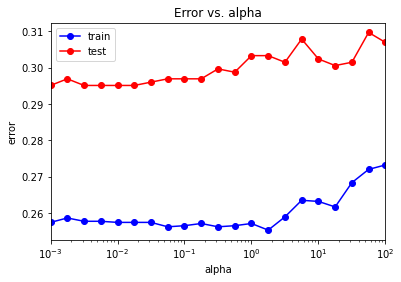

In [37]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()


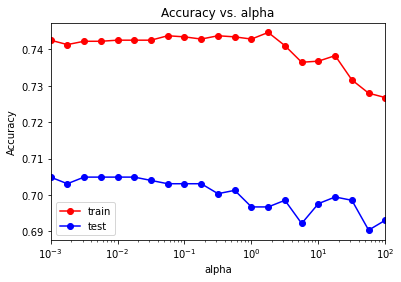

In [38]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

In [39]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.25531268973891924 0.29508196721311475


In [40]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.001      0.00316228 0.00562341 0.01       0.01778279]


In [41]:
alpha_opt = alpha_opt[0]

In [79]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (400,),
                          solver = 'lbfgs', activation = 'logistic',max_iter=1000, random_state = 22)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.222829386763813
0.3005464480874317


### Подбор количества нейтронов

In [82]:
neuron_count_array = np.linspace(1, 250, 24).astype(int)
neuron_count_array 

array([  1,  11,  22,  33,  44,  55,  65,  76,  87,  98, 109, 120, 130,
       141, 152, 163, 174, 185, 195, 206, 217, 228, 239, 250])

In [ ]:
test_error = []
train_error = []
for neuron_count in neuron_count_array:
    model = MLPClassifier(
        alpha=alpha_opt,
        hidden_layer_sizes=(neuron_count,),
        solver='lbfgs',
        activation ='logistic',
        max_iter=1000,
        random_state = 42
    )
    model.fit(X_train, y_train)
    y_train_prediction = model.predict(X_train)
    y_test_prediction = model.predict(X_test)
    test_error.append(np.mean(y_test != y_test_pred))
    train_error.append(np.mean(y_train != y_train_pred))

In [ ]:
min_test_error = np.min(test_error)
neuron_count_optimal = neuron_count_array[test_error == min_test_error][0]
print('Optimal neuron count: {}'.format(neuron_count_optimal))

### Выводы

Ошибка получилась намного больше, чем при применении Деревьев Решений, возможно, эти данные лучше классифицирует этот алгоритм